In [106]:
import os
import sys
from pathlib import Path
baseModulePath = str(Path(os.getcwd()).parents[2].absolute())
if baseModulePath not in sys.path:
	sys.path.append(baseModulePath)

import datetime
import pandas as pd
from analisis.general.io_helper import getMkdir

OBSV_DATE = datetime.date(year=2022, month=11, day=26).strftime("%Y-%m-%d")

OBJ_DATA_DIR = "/run/media/ramon/ROG_Data/Tesis/IturbideDatos/ATOJ339.9469+45.1464"

DATE_DATA_DIR = [os.path.join(OBJ_DATA_DIR, d) for d in os.listdir(OBJ_DATA_DIR) if OBSV_DATE in d and os.path.isdir(os.path.join(OBJ_DATA_DIR, d))][0]
EPOCH_OBSV_KEY = "E_OTIME"

# TODO on run: update this whenever reference star targets change
STAR_IDS = {
	1: "ATO J339.9469+45.1464", # Object

	# Ref stars
	2: "TYC 3620-332-1",
	3: "TYC 3620-254-1"
}

assert os.path.exists(DATE_DATA_DIR), f"{DATE_DATA_DIR} not found"
DATE_DATA_DIR

'/run/media/ramon/ROG_Data/Tesis/IturbideDatos/ATOJ339.9469+45.1464/2022-11-26'

In [96]:
# TODO: turn observed times to UTC; currently in local time only

import numpy as np
from scipy import stats
from astropy.io import ascii

PHOTOMETRIC_BASE_KEYS = ["SUM", "AREA", "FLUX", "MAG", "MERR"]
OBSV_KEY = "OTIME"

qphotResultsDir = os.path.join(DATE_DATA_DIR, "corrected", "iraf-shifted", "qphot-results")
assert os.path.exists(qphotResultsDir), qphotResultsDir

data = ascii.read(os.path.join(qphotResultsDir, "phot"))
pandasData = data.to_pandas()
apertureCols = [c for c in pandasData.columns if c.startswith('RAPERT')]
pandasData[OBSV_KEY] = pd.to_datetime(pandasData[OBSV_KEY])

# https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#from-timestamps-to-epoch
# pandasData[EPOCH_OBSV_KEY] = (pandasData[OBSV_KEY] - pd.Timestamp("1970-01-01")) / pd.Timedelta(hours=1.0)
pandasData[EPOCH_OBSV_KEY] = pd.DatetimeIndex(pandasData[OBSV_KEY]).to_julian_date()

for starId, starName in STAR_IDS.items():
	starData = pandasData[pandasData['LID'] == starId].copy()		
	starResultsDir = getMkdir(os.path.join(qphotResultsDir, starName))
	for rapert in apertureCols:
		apertureId = rapert.replace("RAPERT", "")
		apertureRadius = starData.loc[starData.index[0], f"RAPERT{apertureId}"]
		apertureDir = getMkdir(os.path.join(starResultsDir, f"{rapert} - {apertureRadius}"))
		for basePhotKey in PHOTOMETRIC_BASE_KEYS:
			photKey = f"{basePhotKey}{apertureId}"
			photDf = starData[[EPOCH_OBSV_KEY, photKey]].copy()
			photDf = photDf[~(np.isnan(photDf[photKey]))]
			
			photDf['zscore'] = np.abs(stats.zscore(photDf[photKey]))
			photDf = photDf[(np.abs(stats.zscore(photDf[photKey])) < 2)]

			photDf.to_csv(os.path.join(apertureDir, f"{basePhotKey}.dat"), index=False, sep=' ')

data

IMAGE,XINIT,YINIT,ID,COORDS,LID,XCENTER,YCENTER,XSHIFT,YSHIFT,XERR,YERR,CIER,CERROR,MSKY,STDEV,SSKEW,NSKY,NSREJ,SIER,SERROR,ITIME,XAIRMASS,IFILTER,OTIME,RAPERT1,SUM1,AREA1,FLUX1,MAG1,MERR1,PIER1,PERROR1,RAPERT2,SUM2,AREA2,FLUX2,MAG2,MERR2,PIER2,PERROR2,RAPERT3,SUM3,AREA3,FLUX3,MAG3,MERR3,PIER3,PERROR3,RAPERT4,SUM4,AREA4,FLUX4,MAG4,MERR4,PIER4,PERROR4,RAPERT5,SUM5,AREA5,FLUX5,MAG5,MERR5,PIER5,PERROR5,RAPERT6,SUM6,AREA6,FLUX6,MAG6,MERR6,PIER6,PERROR6,RAPERT7,SUM7,AREA7,FLUX7,MAG7,MERR7,PIER7,PERROR7,RAPERT8,SUM8,AREA8,FLUX8,MAG8,MERR8,PIER8,PERROR8,RAPERT9,SUM9,AREA9,FLUX9,MAG9,MERR9,PIER9,PERROR9,RAPERT10,SUM10,AREA10,FLUX10,MAG10,MERR10,PIER10,PERROR10
imagename,pixels,pixels,,filename,,pixels,pixels,pixels,pixels,pixels,pixels,,cerrors,counts,counts,counts,npix,npix,,serrors,timeunit,number,name,timeunit,scale,counts,pixels,counts,mag,mag,,perrors,scale,counts,pixels,counts,mag,mag,,perrors,scale,counts,pixels,counts,mag,mag,,perrors,scale,counts,pixels,counts,mag,mag,,perrors,scale,counts,pixels,counts,mag,mag,,perrors,scale,counts,pixels,counts,mag,mag,,perrors,scale,counts,pixels,counts,mag,mag,,perrors,scale,counts,pixels,counts,mag,mag,,perrors,scale,counts,pixels,counts,mag,mag,,perrors,scale,counts,pixels,counts,mag,mag,,perrors
str23,float64,float64,int64,str6,int64,float64,float64,float64,float64,float64,float64,int64,str8,float64,float64,float64,int64,int64,int64,str7,float64,float64,str1,str23,float64,float64,float64,float64,float64,float64,int64,str7,float64,float64,float64,float64,float64,float64,int64,str7,float64,float64,float64,float64,float64,float64,int64,str7,float64,float64,float64,float64,float64,float64,int64,str7,float64,float64,float64,float64,float64,float64,int64,str7,float64,float64,float64,float64,float64,float64,int64,str7,float64,float64,float64,float64,float64,float64,int64,str7,float64,float64,float64,float64,float64,float64,int64,str7,float64,float64,float64,float64,float64,float64,int64,str7,float64,float64,float64,float64,float64,float64,int64,str7
s_bdf_2022-11-26_23-13-,937.500,518.606,1,coords,1,937.863,519.515,0.363,0.909,0.016,0.018,0,NoError,226.6939,31.65167,17.71216,3457,80,0,NoError,60,1.747969,--,2022-11-26T23:13:51.230,9.00,81143.88,254.5111,23447.78,18.520,0.024,0,NoError,10.00,97362.87,314.5593,26054.21,18.406,0.025,0,NoError,11.00,114602.6,380.5743,28328.71,18.315,0.025,0,NoError,12.00,132777.8,452.2508,30255.33,18.243,0.026,0,NoError,13.00,152073.8,531.5282,31579.57,18.197,0.027,0,NoError,14.00,171842.4,615.8068,32242.73,18.174,0.029,0,NoError,22.00,375285.1,1520.831,30521.98,18.234,0.053,0,NoError,23.00,406428.3,1662.536,29541.54,18.269,0.058,0,NoError,25.00,473142.1,1964.229,27863.3,18.333,0.068,0,NoError,28.00,584639.6,2463.31,26222.28,18.399,0.085,0,NoError
s_bdf_2022-11-26_23-13-,1151.901,95.893,2,coords,2,1151.751,96.273,-0.150,0.380,0.002,0.002,0,NoError,248.9117,38.01779,26.25418,3389,149,0,NoError,60,1.747969,--,2022-11-26T23:13:51.230,9.00,2853534,254.7236,2790130,13.331,0.000,0,NoError,10.00,3185893,314.5161,3107606,13.214,0.000,0,NoError,11.00,3470149,380.371,3375470,13.125,0.000,0,NoError,12.00,3709647,452.633,3596982,13.056,0.000,0,NoError,13.00,3908902,531.1226,3776699,13.003,0.000,0,NoError,14.00,4075139,616.0077,3921807,12.962,0.000,0,NoError,22.00,4763826,1520.768,4385290,12.840,0.000,0,NoError,23.00,4818830,1662.241,4405078,12.835,0.000,0,NoError,25.00,4922726,1963.757,4433923,12.828,0.001,0,NoError,28.00,5076523,2463.207,4463402,12.821,0.001,0,NoError
s_bdf_2022-11-26_23-13-,1364.127,885.601,3,coords,3,1364.194,887.001,0.067,1.400,0.003,0.003,107,BigShift,235.6384,32.28704,16.1781,3513,17,0,NoError,60,1.747969,--,2022-11-26T23:13:51.230,9.00,1733229,254.9056,1673163,13.887,0.000,0,NoError,10.00,1939955,314.255,1865904,13.768,0.000,0,NoError,11.00,2119298,380.328,2029678,13.677,0.000,0,NoError,12.00,2272023,453.0005,2165279,13.607,0.000,0,NoError,13.00,2397764,530.9375,2272655,13.554,0.000,0,NoError,14.00,2505102,616.1777,2359907,13.513,0.000,0,NoError,22.00

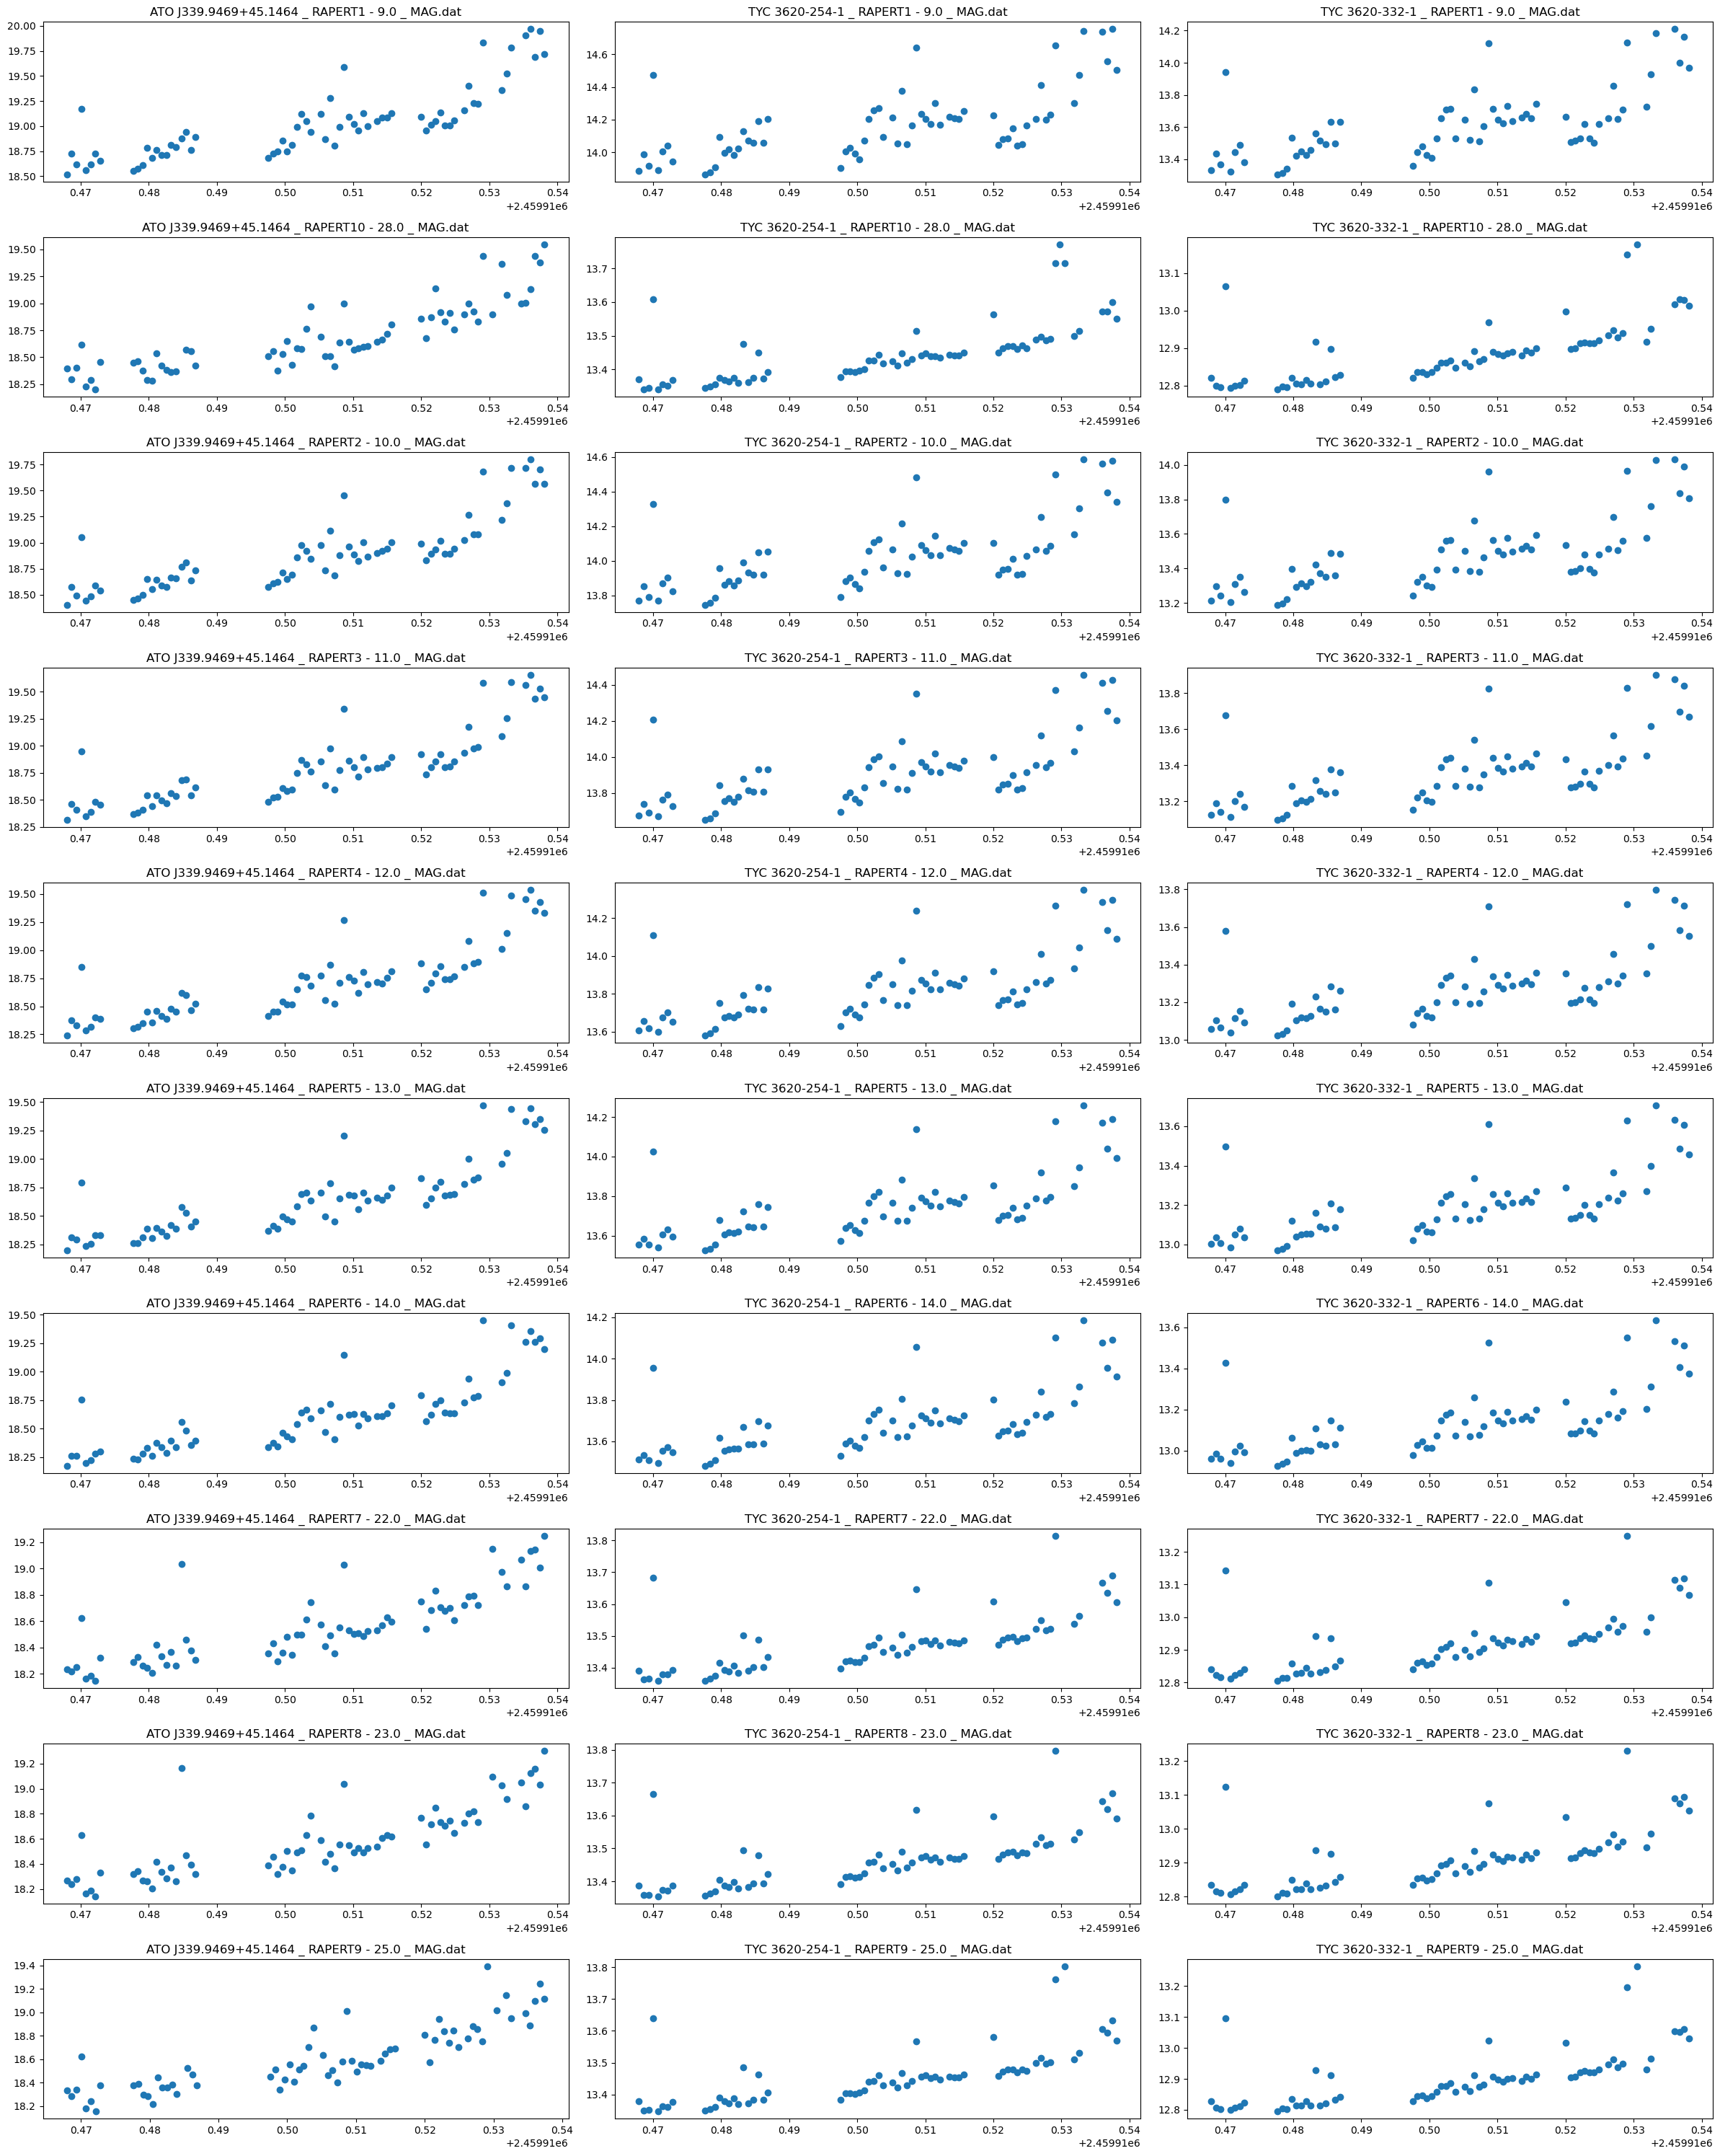

In [107]:
import matplotlib.pyplot as plt
# plt.rcParams["figure.figsize"] = (15,20)

FILE = "MAG.dat"
COL =  "MAG"
OBJ_NAMES = ["ATO J339.9469+45.1464", "TYC 3620-254-1","TYC 3620-332-1"]

qphotResultsDir = os.path.join(DATE_DATA_DIR, "corrected", "iraf-shifted", "qphot-results")

numApertures = len(os.listdir(os.path.join(qphotResultsDir, OBJ_NAMES[0])))
figure, axs = plt.subplots(nrows=numApertures, ncols=len(OBJ_NAMES), figsize=(24, 30))

def plotApertureMags(subplots, objName: str):
	objDir = os.path.join(qphotResultsDir, objName)
	apertureDirs = os.listdir(objDir)
	for i in range(len(subplots)):
		curApertureDir = os.path.join(objDir, apertureDirs[i])
		objData = pd.read_csv(os.path.join(curApertureDir, FILE), sep=' ')
		dataCol = [c for c in objData.columns if COL in c][0]
		
		subplots[i].scatter(objData[EPOCH_OBSV_KEY], objData[dataCol])
		subplots[i].set_title(f"{objName} _ {apertureDirs[i]} _ {FILE}")

for i in range(len(OBJ_NAMES)):
	subplots = axs[:, i]
	plotApertureMags(subplots, OBJ_NAMES[i])

figure.tight_layout()
plt.show()